# **Case Datarisk - Score de Crédito**

## **Importa as bibliotecas e Carrega os Dados**

In [1]:
import sys
import os

# Pega o diretório de trabalho atual (que é /notebooks)
notebook_dir = os.getcwd()
# Sobe um nível para o diretório raiz do projeto
project_root = os.path.abspath(os.path.join(notebook_dir, '..'))

# Adiciona a raiz do projeto ao sys.path se ainda não estiver lá
if project_root not in sys.path:
    print(f"Adicionando a raiz do projeto ao path: {project_root}")
    sys.path.append(project_root)

Adicionando a raiz do projeto ao path: /teamspace/studios/this_studio/case-ds


In [15]:
from src.load_df import load_df
from src.convert_to_datetime import convert_to_datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker

from pathlib import Path
import joblib

import lightgbm as lgb
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve, auc

import lightgbm as lgb
import xgboost as xgb
import catboost as cat

from boruta import BorutaPy
import optuna

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer 

In [3]:
pd.options.display.max_rows = None

In [4]:
# Carregar os DataFrames
df_train = load_df("../data/train.parquet")
X_train = df_train.drop('inadimplente', axis=1)
y_train = df_train['inadimplente']

df_test = load_df("../data/test.parquet")
X_test = df_test.drop('inadimplente', axis=1)
y_test = df_test['inadimplente']

df_val= load_df("../data/validation.parquet")
X_val = df_val.drop('inadimplente', axis=1)
y_val = df_val['inadimplente']

## **Modelagem**

### **Funções**


In [5]:
def fit_and_predict(model, X_train=X_train, y_train=y_train, X_test=X_test):

  # Treinar o modelo
  model.fit(X_train, y_train)

  # Fazer previsões no conjunto de teste
  y_pred_proba = model.predict_proba(X_test)[:, 1]
  y_pred = model.predict(X_test)

  return y_pred_proba, y_pred


In [6]:
def save_model_and_metrics(model, metrics, model_name):

    model_package = {
        'model': model,
        'metrics': metrics
    }

    model_dir = os.path.join(project_root, 'models')
    os.makedirs(model_dir, exist_ok=True)

    # Define o caminho completo do arquivo
    model_path = os.path.join(model_dir, f"{model_name}.joblib")

    joblib.dump(model_package, model_path)

    print(f"Modelo salvo em: {model_path}")

In [7]:
def plotProbHistograms(y_pred_proba, y_test, ax):
  """
  Gera e exibe histogramas das probabilidades previstas para múltiplos modelos
  em um eixo matplotlib específico.

  Args:
      y_pred_proba (np.array): Probabilidades previstas para a classe positiva (1).
      y_test (pd.Series): Valores verdadeiros da target.
      ax (matplotlib.axes.Axes): O eixo onde os histogramas serão desenhados.
  """

  df_plot = pd.DataFrame({
      'Probabilidade': y_pred_proba,
      'Classe': y_test.astype(int)
  })

  # Para cada classe, faz um subplot no eixo fornecido
  sns.histplot(
      data=df_plot[df_plot['Classe'] == 0],
      x='Probabilidade',
      bins=30,
      stat='density',
      color='blue',
      label='Classe 0 (Não Inadimplente)',
      kde=True, # Adicionar Kernel Density Estimate para suavizar o histograma
      ax=ax # Especifica o eixo para plotar
  )
  sns.histplot(
      data=df_plot[df_plot['Classe'] == 1],
      x='Probabilidade',
      bins=30,
      stat='density',
      color='red',
      label='Classe 1 (Inadimplente)',
      kde=True, # Adicionar Kernel Density Estimate para suavizar o histograma
      ax=ax # Especifica o eixo para plotar
  )

  ax.set_title('Distribuição das Probabilidades Previstas por Classe', fontsize=14)
  ax.set_xlabel('Probabilidade Prevista')
  ax.set_ylabel('Densidade')
  ax.legend()
  ax.grid(True)

In [8]:
def plot_ks_curve(y_true, y_probas_positive, title='Curva KS', ax=None):
    """
    Plota a curva KS (Kolmogorov-Smirnov) para um modelo de classificação binária.
    A visualização do KS foi melhorada para ser visível mesmo com valores muito baixos.
    """
    # 1. Cria um DataFrame com os dados (sem alterações)
    df = pd.DataFrame({
        'y_true': y_true,
        'y_proba': y_probas_positive
    })
    df = df.sort_values(by='y_proba').reset_index(drop=True)

    # 2. Calcula as distribuições acumuladas (sem alterações)
    total_positives = df['y_true'].sum()
    total_negatives = len(df) - total_positives
    
    # Adicionado um pequeno valor (epsilon) para evitar divisão por zero se uma classe não estiver presente
    if total_positives == 0 or total_negatives == 0:
        print("Aviso: Dados de entrada contêm apenas uma classe. A curva KS não pode ser calculada.")
        return 0, 0, ax
        
    df['cdf_positive'] = df['y_true'].cumsum() / total_positives
    df['cdf_negative'] = (1 - df['y_true']).cumsum() / total_negatives

    # 3. Calcula o KS (sem alterações)
    df['ks'] = abs(df['cdf_positive'] - df['cdf_negative'])
    ks_statistic = df['ks'].max()
    
    best_threshold_row = df.loc[df['ks'].idxmax()]
    best_threshold = best_threshold_row['y_proba']
    y_positive_at_ks = best_threshold_row['cdf_positive']
    y_negative_at_ks = best_threshold_row['cdf_negative']

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    # 5. Plot das curvas e do KS (ESTA PARTE FOI ALTERADA)
    ax.plot(df['y_proba'], df['cdf_positive'], label='CDF Positivos (Classe 1)')
    ax.plot(df['y_proba'], df['cdf_negative'], label='CDF Negativos (Classe 0)')
    
    ax.plot([best_threshold, best_threshold], [y_negative_at_ks, y_positive_at_ks],
            linestyle='--', color='red', label=f'KS = {ks_statistic:.4f}')

    # Adiciona uma anotação com uma seta para mostrar a distância exata
    ax.annotate(
        f'KS = {ks_statistic:.4f}',
        xy=(best_threshold, y_negative_at_ks),
        xytext=(best_threshold + 0.1, y_negative_at_ks + 0.2), # Posição do texto
        arrowprops=dict(facecolor='black', shrink=0.05),
        horizontalalignment='center',
        verticalalignment='bottom'
    )
    
    # 6. Estilização do gráfico (sem alterações)
    ax.set_title(title)
    ax.set_xlabel('Probabilidade (Score)')
    ax.set_ylabel('Percentual Acumulado')
    ax.legend()
    ax.grid(True)
    
    return ks_statistic, best_threshold

In [20]:
def plot_feature_importance(model, feature_names, ax=None):
  if ax is None:
    fig, ax = plt.subplots(figsize=(8, 6))

  feature_importances = get_feature_importance_df(model, feature_names).head(10)

  # Plotar a importância das features
  sns.barplot(x='Importance', y='Feature', data=feature_importances, ax=ax)
  ax.set_title('Importância das Features')
  ax.set_xlabel('Importância')
  ax.set_ylabel('Feature')

def get_feature_importance_df(model, feature_names):
  # Extrair a importância das features
  importances = model.feature_importances_
  feature_names = feature_names
  feature_importances = pd.DataFrame({
      'Feature': feature_names,
      'Importance': importances
  }).sort_values(by='Importance', ascending=False)
  
  return feature_importances

In [10]:
def evaluate_metrics(y_test, y_pred_proba):
    """
    Calcula as principais métricas de avaliação para um modelo de classificação binária.
    Retorna um DataFrame com os valores.
    """

    # AUC ROC
    auc_score = roc_auc_score(y_test, y_pred_proba)

    # Curva PR e PR-AUC
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc_score = auc(recall_curve, precision_curve)

    # Estatística KS (corrigida)
    df_ks = pd.DataFrame({'proba': y_pred_proba, 'target': y_test})
    df_ks = df_ks.sort_values('proba', ascending=False).reset_index(drop=True)

    df_ks['cum_pos'] = (df_ks['target'] == 1).cumsum() / (df_ks['target'] == 1).sum()
    df_ks['cum_neg'] = (df_ks['target'] == 0).cumsum() / (df_ks['target'] == 0).sum()
    df_ks['ks'] = df_ks['cum_pos'] - df_ks['cum_neg']

    ks_score = df_ks['ks'].max()
    ks_index = df_ks['ks'].idxmax()
    ks_threshold = df_ks['proba'].iloc[ks_index]

    # Precision e Recall no threshold KS
    precision = precision_score(y_test, y_pred_proba >= ks_threshold)
    recall = recall_score(y_test, y_pred_proba >= ks_threshold)

    metrics = pd.DataFrame({
        'Métrica': [
            'AUC (ROC)',
            'PR-AUC',
            'KS Statistic',
            'KS Threshold',
            'Precision (no KS)',
            'Recall (no KS)'
        ],
        'Valor': [
            round(auc_score, 4),
            round(pr_auc_score, 4),
            round(ks_score, 4),
            round(ks_threshold, 4),
            round(precision, 4),
            round(recall, 4)
        ]
    })

    return metrics


def show_report(model, experiment_name, feature_names, y_test, y_pred_proba):
    """
    Gera um dashboard 2x2 com as principais métricas de avaliação para um modelo de classificação binária.
    Inclui AUC, PR-AUC, KS e distribuição de probabilidades.
    """

    # 1. CÁLCULO DAS MÉTRICAS
    metrics = evaluate_metrics(y_test, y_pred_proba)
    display(metrics)

    auc_score = metrics.loc[metrics['Métrica'] == 'AUC (ROC)', 'Valor'].values[0]
    pr_auc_score = metrics.loc[metrics['Métrica'] == 'PR-AUC', 'Valor'].values[0]

    # Curva Precision-Recall
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)

    # Curva ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

    # 2. DASHBOARD 2x2
    fig, axes = plt.subplots(2, 2, figsize=(12, 9))
    fig.suptitle(f"Relatório de Performance - {experiment_name}", fontsize=18)

    # --- Gráfico 1: Curva ROC ---
    ax1 = axes[0, 0]
    ax1.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}', color='darkorange')
    ax1.plot([0, 1], [0, 1], color='navy', linestyle='--')
    ax1.set_title('Curva ROC', fontsize=14)
    ax1.set_xlabel('FPR (Taxa de Falsos Positivos)')
    ax1.set_ylabel('TPR (Taxa de Verdadeiros Positivos)')
    ax1.legend()
    ax1.grid(True)

    # --- Gráfico 2: Curva KS ---
    from matplotlib.ticker import PercentFormatter
    ax2 = axes[0, 1]
    ks_value, best_threshold = plot_ks_curve(y_test, y_pred_proba, ax=ax2)
    ax2.yaxis.set_major_formatter(PercentFormatter(1.0))
    ax2.set_title(f'Curva KS (KS={ks_value:.2%})', fontsize=14)

    # --- Gráfico 3: Distribuição das Probabilidades ---
    ax3 = axes[1, 0]
    plotProbHistograms(y_pred_proba, y_test, ax=ax3)
    ax3.set_title('Distribuição das Probabilidades', fontsize=14)

    # --- Gráfico 4: Importância das Features ---
    ax4 = axes[1, 1]
    plot_feature_importance(model, feature_names, ax=ax4)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [11]:
def get_scale_pos_weight(y_train):
    '''
    Calcula o scale_pos_weight para o XGBoost com base na distribuição das classes.
    '''
    return (y_train == 0).sum() / (y_train == 1).sum()

In [12]:
def run_experiment(model, experiment_name, display_report=True, save_model=True,
                   X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    ''''
    Executa o experimento completo: 
        - treina o modelo com X_train e y_train, 
        - avalia o modelo com X_test e y_test, 
        - exibe o relatório 
        - salva o modelo e métricas.
    '''
    feature_names = X_train.columns.tolist()

    y_pred_proba, y_pred = fit_and_predict(model, X_train, y_train, X_test)

    metrics = evaluate_metrics(y_test, y_pred_proba)

    if display_report:
        show_report(model, experiment_name, feature_names, y_test, y_pred_proba)

    if save_model:
        save_model_and_metrics(model, metrics, experiment_name)

## **Experimentos**

### Baseline

,Métrica,Valor
0,AUC (ROC),0.6206
1,PR-AUC,0.0061
2,KS Statistic,0.2513
3,KS Threshold,0.1240
4,Precision (no KS),0.0067
5,Recall (no KS),0.6000


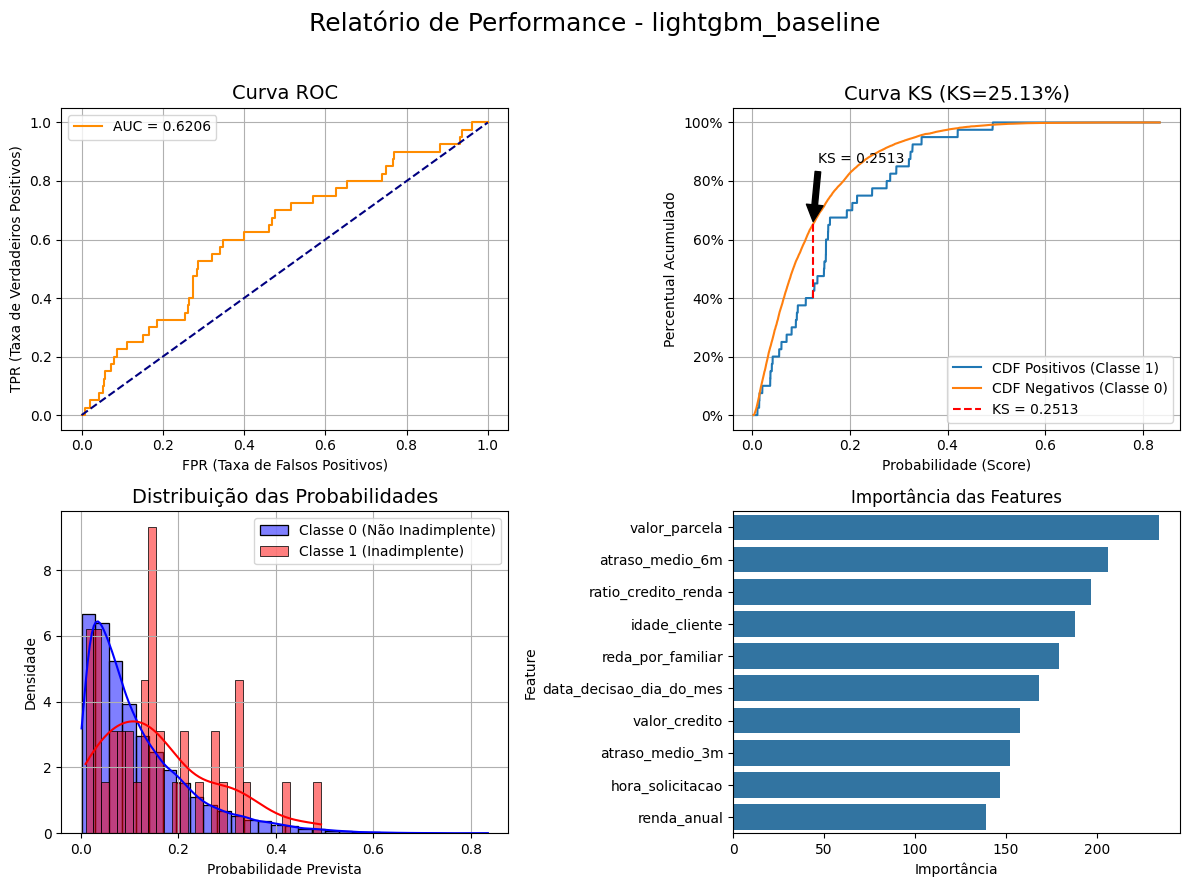

Modelo salvo em: /Users/jvlm/repositories/case-ds/models/lightgbm_baseline.joblib


,Métrica,Valor
0,AUC (ROC),0.6132
1,PR-AUC,0.0066
2,KS Statistic,0.2456
3,KS Threshold,0.0136
4,Precision (no KS),0.0060
5,Recall (no KS),0.7000


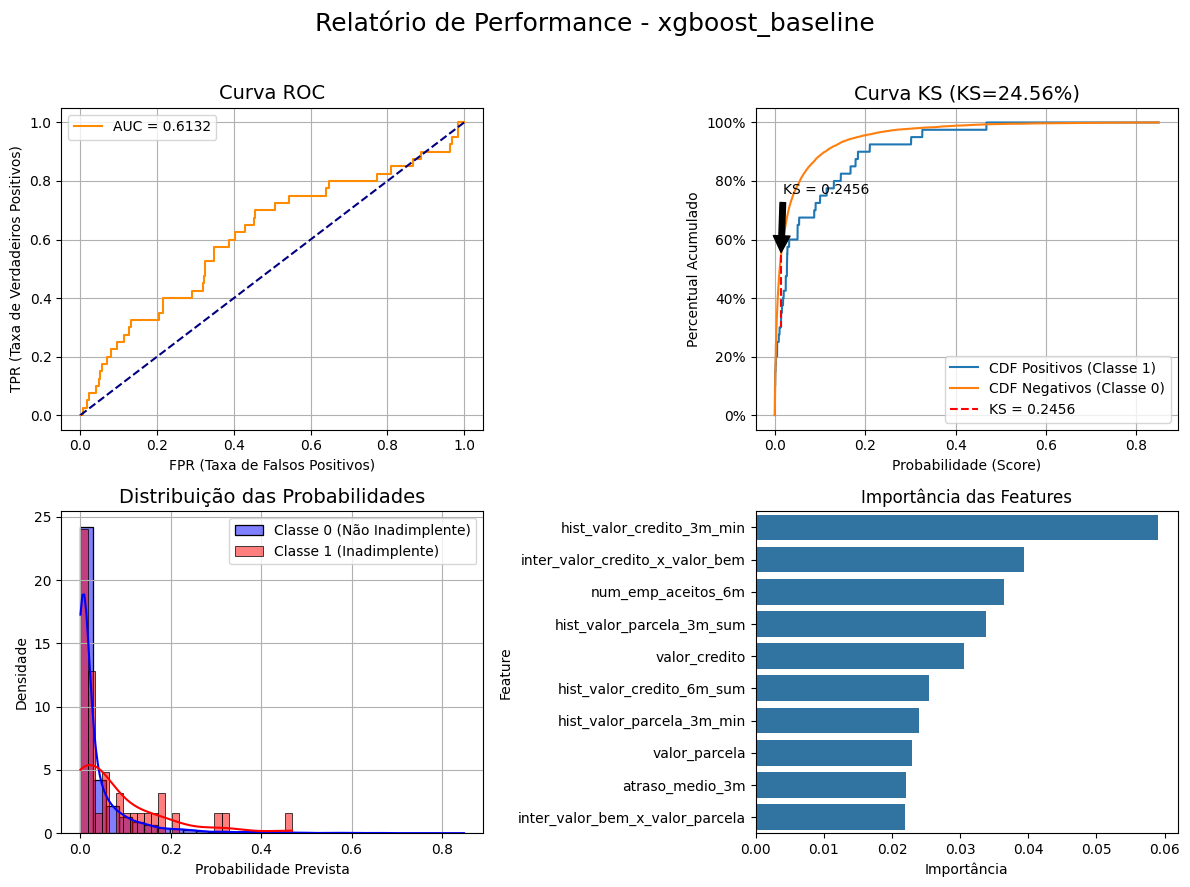

Modelo salvo em: /Users/jvlm/repositories/case-ds/models/xgboost_baseline.joblib


,Métrica,Valor
0,AUC (ROC),0.6493
1,PR-AUC,0.0086
2,KS Statistic,0.2808
3,KS Threshold,0.0700
4,Precision (no KS),0.0083
5,Recall (no KS),0.5250


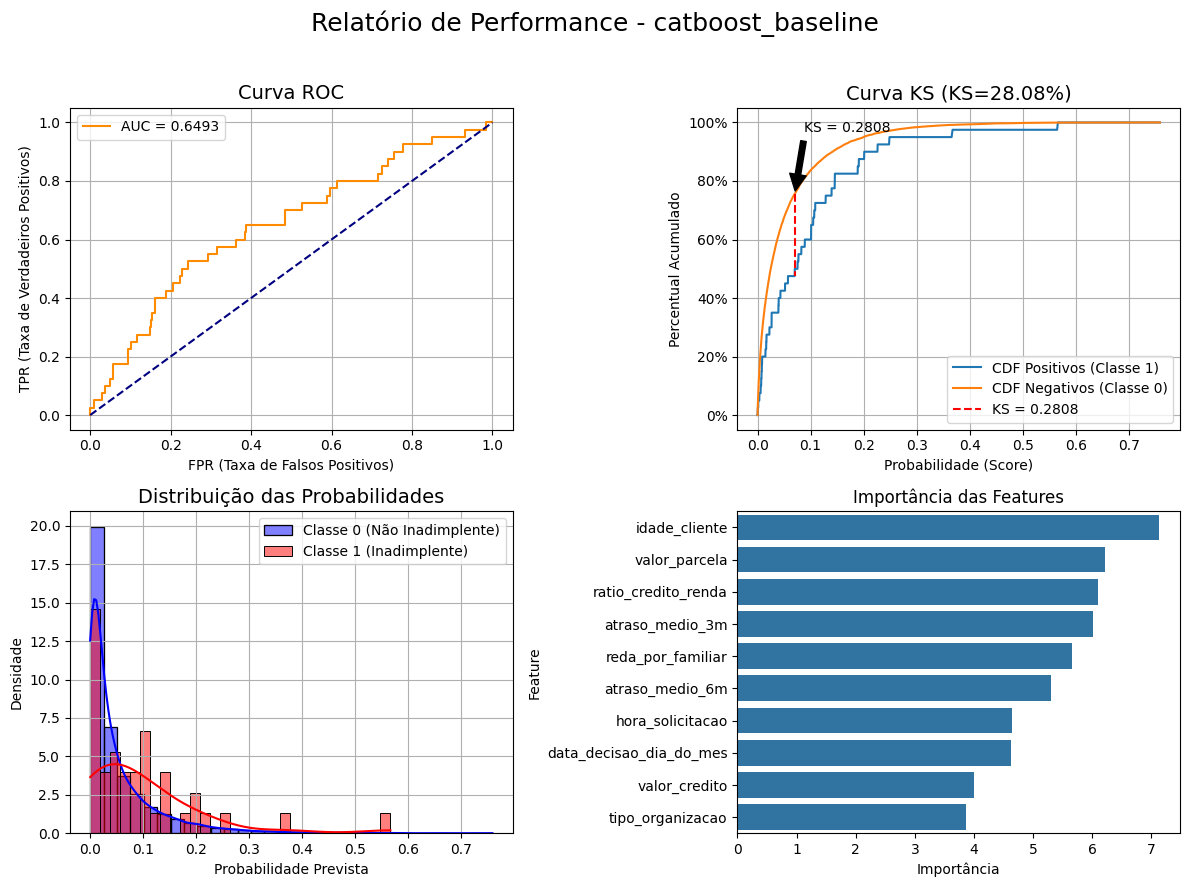

Modelo salvo em: /Users/jvlm/repositories/case-ds/models/catboost_baseline.joblib


In [ ]:
params_lgbm = {
    'class_weight': 'balanced',
    'seed': 42,
    'verbosity': -1  # silencia logs do LightGBM
}

params_xgboost = {
    'scale_pos_weight': get_scale_pos_weight(y_train),
    'seed': 42,
    'verbosity': 0,         # silencia logs do XGBoost
    'use_label_encoder': False
}

params_catboost = {
    'auto_class_weights': 'Balanced',
    'random_seed': 42,
    'logging_level': 'Silent'  # manter apenas logging_level
}

# Criar os modelos baseline
model_lgbm = lgb.LGBMClassifier(**params_lgbm)
model_xgboost = xgb.XGBClassifier(**params_xgboost)
model_catboost = cat.CatBoostClassifier(**params_catboost)

# Executar experimentos baseline (apenas uma vez)
run_experiment(model_lgbm, experiment_name='lightgbm_baseline')
run_experiment(model_xgboost, experiment_name='xgboost_baseline')
run_experiment(model_catboost, experiment_name='catboost_baseline')

### Threashold Manual de Feature Importance

In [153]:
def train_with_most_important_features(model, num_features=5,
                                 X_train=X_train, y_train=y_train,
                                 X_val=X_val, y_val=y_val):
    '''
    Treina o modelo utilizando apenas as features com importância acima do threshold especificado.
    Retorna as features usadas e o score AUC.
    '''

    feature_importances = get_feature_importance_df(model, feature_names=X_train.columns.to_list())
    features_to_keep = feature_importances['Feature'].head(num_features).tolist()

    X_train_reduced = X_train[features_to_keep]
    X_val_reduced = X_val[features_to_keep]

    model_class = type(model)
    
    # pega os hiperparâmetros do modelo original
    model_params = model.get_params()

    # cria uma nova instância do modelo com os mesmos hiperparâmetros
    new_model_instance = model_class(**model_params)

    new_model_instance.fit(X_train_reduced, y_train)

    y_pred_proba, _ = fit_and_predict(new_model_instance, X_train_reduced, y_train, X_val_reduced)
    auc_score = roc_auc_score(y_val, y_pred_proba)

    return features_to_keep, auc_score


In [158]:
from tqdm.auto import tqdm

def test_features_by_importance(model, X_train=X_train, y_train=y_train,
                                X_val=X_val, y_val=y_val):
    '''
    Testa o desempenho do modelo utilizando diferentes números de features mais importantes.
    '''

    progress_bar = tqdm(range(1, X_train.shape[1] + 1), desc="Testando número de features")

    results = []

    for num_features in progress_bar:
        features_kept, auc_score = train_with_most_important_features(
            model, num_features=num_features,
            X_train=X_train, y_train=y_train,
            X_val=X_val, y_val=y_val
        )
        results.append((features_kept, num_features, auc_score))
        progress_bar.set_postfix(AUC=f"{auc_score:.3f}")

    results_df = pd.DataFrame(results, columns=['Features', 'Num_Features', 'AUC'])

    best_result = results_df.loc[results_df['AUC'].idxmax()]
    features_to_keep = best_result['Features']

    print("\nOtimização concluída.")
    print(f"Melhor AUC: {best_result['AUC']:.4f} com {best_result['Num_Features']} features.")

    display(results_df[['Num_Features', 'AUC']])

    return features_to_keep

In [159]:
features_to_keep = test_features_by_importance(model_lgbm)

Testando número de features: 100%|██████████| 61/61 [01:36<00:00,  1.58s/it, AUC=0.593]


Otimização concluída.
Melhor AUC: 0.6505 com 15 features.


,Num_Features,AUC
0,1,0.539087
1,2,0.539941
2,3,0.564892
3,4,0.536179
4,5,0.570521
5,6,0.577179
6,7,0.616841
7,8,0.605588
8,9,0.601894
9,10,0.620888


,Métrica,Valor
0,AUC (ROC),0.6097
1,PR-AUC,0.0065
2,KS Statistic,0.2475
3,KS Threshold,0.1478
4,Precision (no KS),0.0071
5,Recall (no KS),0.5500


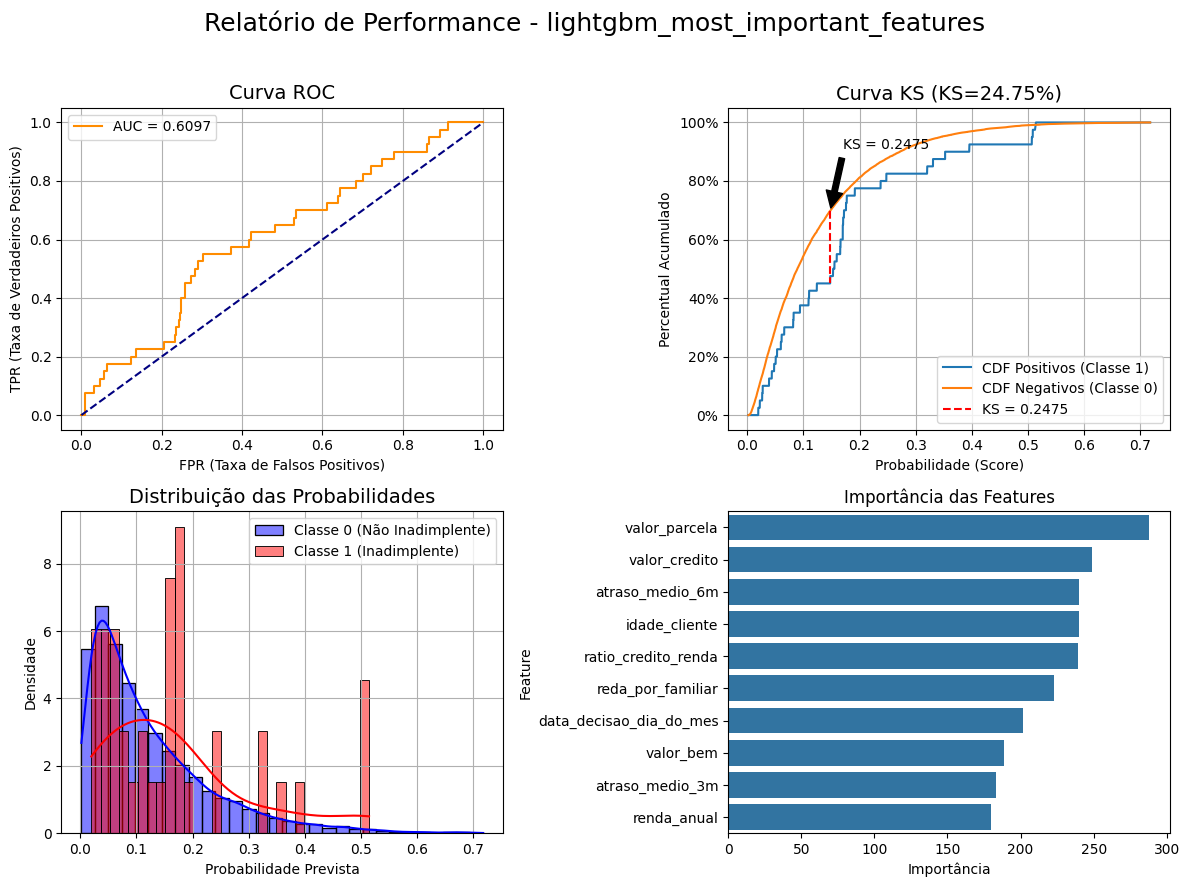

Modelo salvo em: /Users/jvlm/repositories/case-ds/models/lightgbm_most_important_features.joblib


In [160]:
run_experiment(model_lgbm, experiment_name='lightgbm_most_important_features',
               X_train=X_train[features_to_keep], y_train=y_train,
               X_test=X_test[features_to_keep], y_test=y_test)

In [161]:
features_to_keep = test_features_by_importance(model_xgboost)

Testando número de features: 100%|██████████| 61/61 [00:36<00:00,  1.65it/s, AUC=0.561]


Otimização concluída.
Melhor AUC: 0.6254 com 29 features.


,Num_Features,AUC
0,1,0.505133
1,2,0.569484
2,3,0.502942
3,4,0.498717
4,5,0.509656
5,6,0.530783
6,7,0.539973
7,8,0.526508
8,9,0.532387
9,10,0.504567


,Métrica,Valor
0,AUC (ROC),0.6323
1,PR-AUC,0.0094
2,KS Statistic,0.2203
3,KS Threshold,0.0095
4,Precision (no KS),0.0053
5,Recall (no KS),0.8500


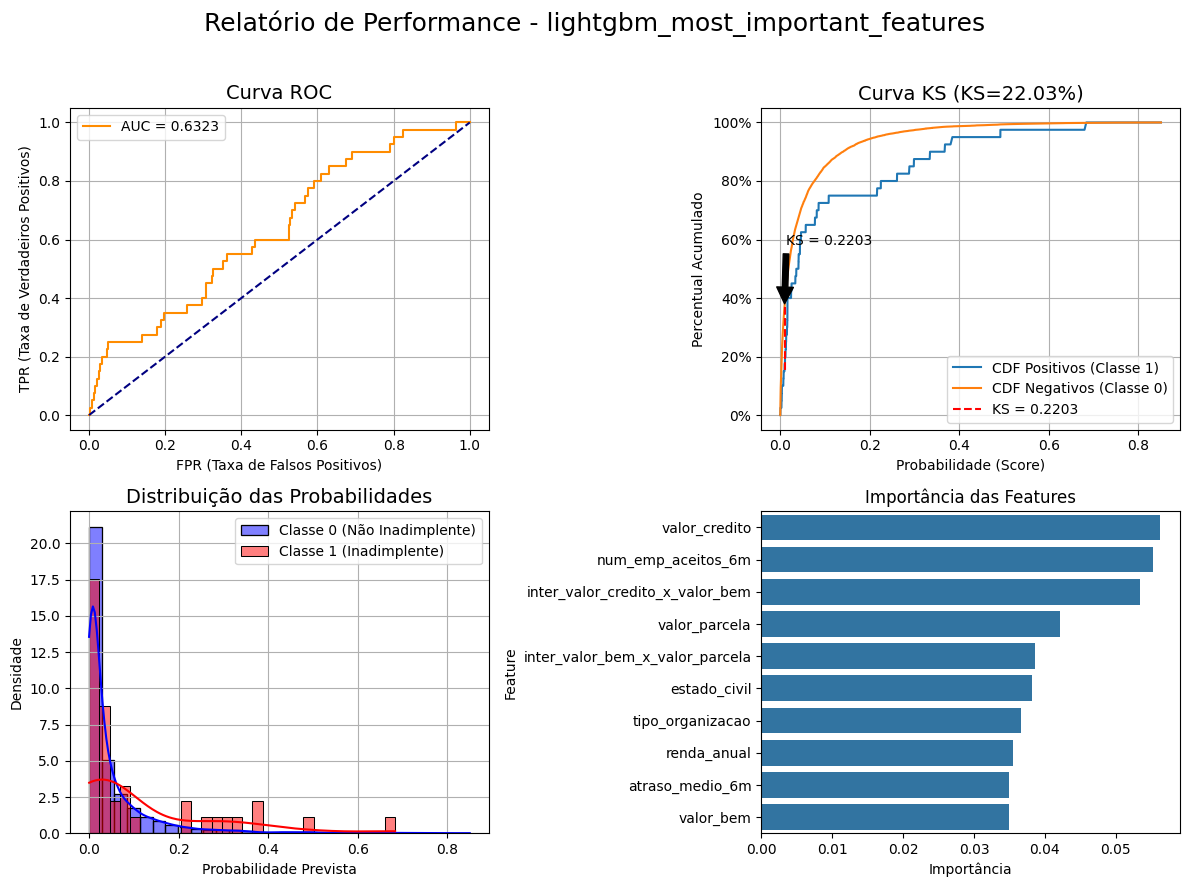

Modelo salvo em: /Users/jvlm/repositories/case-ds/models/lightgbm_most_important_features.joblib


In [162]:
run_experiment(model_xgboost, experiment_name='lightgbm_most_important_features',
               X_train=X_train[features_to_keep], y_train=y_train,
               X_test=X_test[features_to_keep], y_test=y_test)

In [163]:
features_to_keep = test_features_by_importance(model_catboost)

Testando número de features: 100%|██████████| 61/61 [10:46<00:00, 10.60s/it, AUC=0.577]


Otimização concluída.
Melhor AUC: 0.5932 com 44 features.


,Num_Features,AUC
0,1,0.512544
1,2,0.493124
2,3,0.515644
3,4,0.504639
4,5,0.525181
5,6,0.541216
6,7,0.529277
7,8,0.522362
8,9,0.545660
9,10,0.555078


,Métrica,Valor
0,AUC (ROC),0.6439
1,PR-AUC,0.0067
2,KS Statistic,0.2574
3,KS Threshold,0.0353
4,Precision (no KS),0.0063
5,Recall (no KS),0.6750


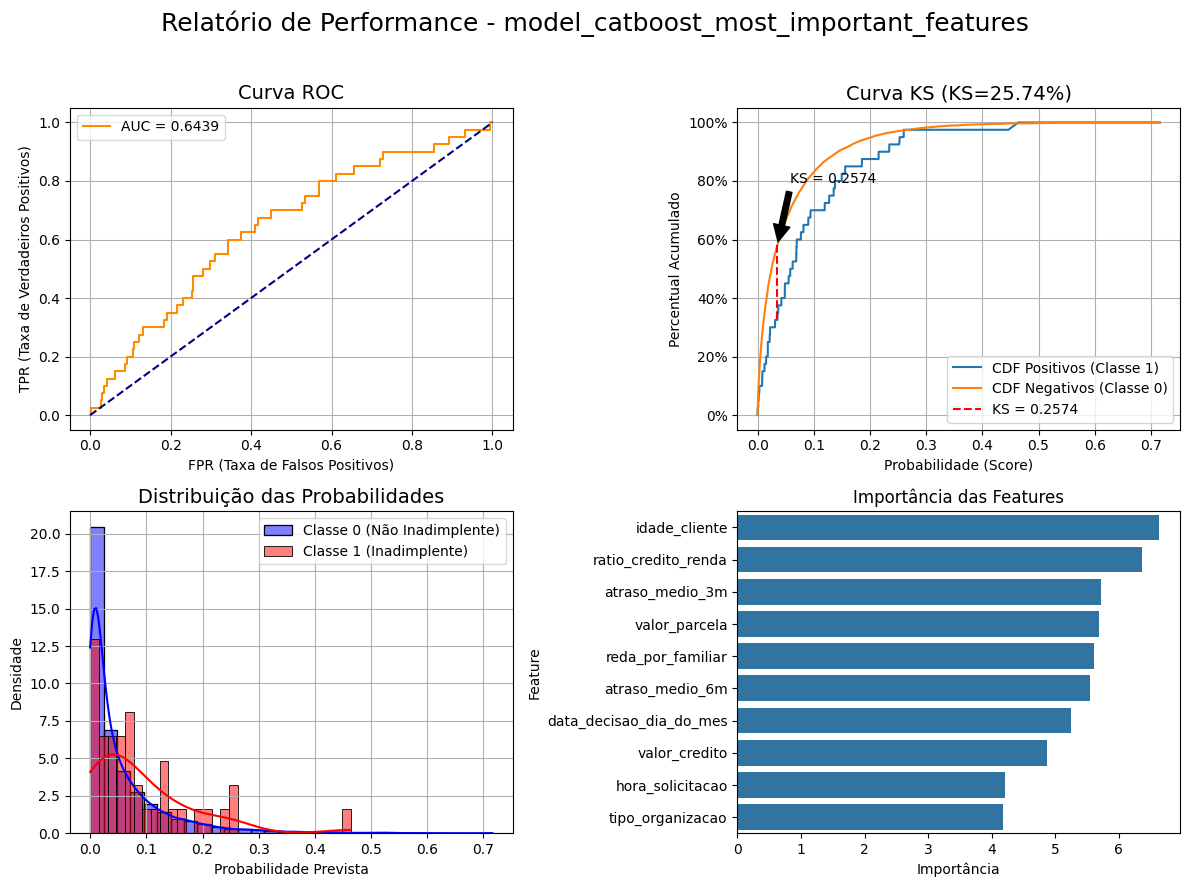

Modelo salvo em: /Users/jvlm/repositories/case-ds/models/model_catboost_most_important_features.joblib


In [164]:
run_experiment(model_catboost, experiment_name='model_catboost_most_important_features',
               X_train=X_train[features_to_keep], y_train=y_train,
               X_test=X_test[features_to_keep], y_test=y_test)

In [531]:
na_cols = X_train.isna().sum()
na_cols = na_cols[na_cols > 0]
if not na_cols.empty:
    display(na_cols)
else:
    print('Não há valores NA em X_train')

y_na = y_train.isna().sum()
if y_na > 0:
    display(y_na)
else:
    print('Não há valores NA em y_train')

Não há valores NA em X_train
Não há valores NA em y_train


,Métrica,Valor
0,AUC (ROC),0.6130
1,PR-AUC,0.0055
2,KS Statistic,0.1992
3,KS Threshold,0.2188
4,Precision (no KS),0.0059
5,Recall (no KS),0.6591


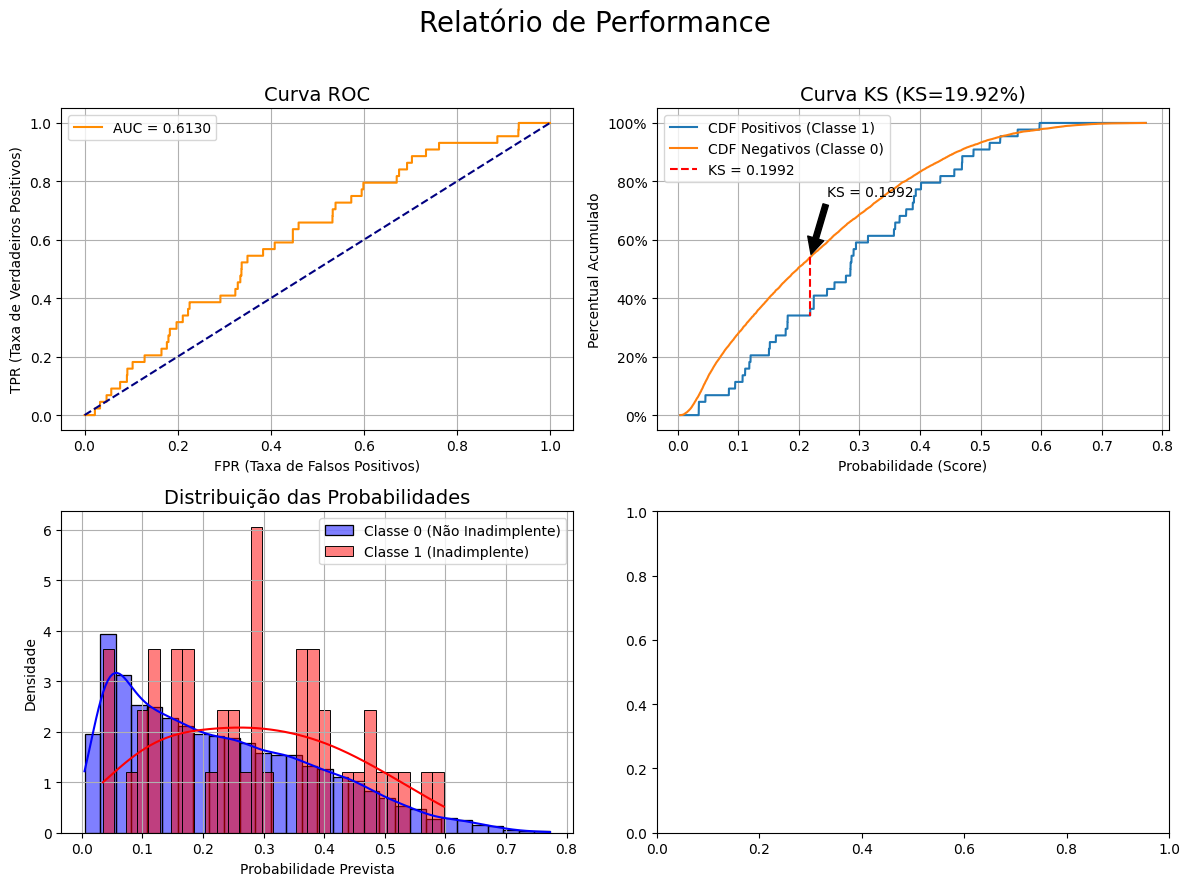

In [ ]:
show_report(model, y_test, y_pred_proba)

## Seleção de Features com Boruta

In [188]:
from sklearn.model_selection import StratifiedKFold
from collections import Counter

def select_features_boruta(X_train, y_train, n_splits=5, max_iter=100, selection_threshold=0.5):
    """
    Realiza a seleção de features usando BorutaPy dentro de uma validação cruzada Stratified K-Fold.
    Seleciona features confirmadas em pelo menos 'selection_threshold' proporção das folds.

    Args:
        X_train (pd.DataFrame): DataFrame com as features de treinamento.
        y_train (pd.Series ou np.array): Variável alvo do treinamento.
        n_splits (int): Número de folds para a validação cruzada.
        max_iter (int): Número máximo de iterações para o Boruta em cada fold.
        selection_threshold (float): Proporção de folds em que uma feature deve ser confirmada para ser selecionada (0 a 1).

    Returns:
        list: Lista com os nomes das features selecionadas consistentemente.
    """
    print(f"Iniciando seleção de features com Boruta usando {n_splits}-Fold CV...")

    # Garante que y_train seja um array numpy 1D
    y_train_values = y_train.squeeze().values
    X_train_values = X_train.values # Boruta funciona melhor com arrays numpy
    feature_names = X_train.columns

    # Usa StratifiedKFold para tarefas de classificação
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Dicionário para contar quantas vezes cada feature é confirmada
    feature_confirmation_counts = Counter()
    total_confirmed_in_folds = 0

    fold_num = 0
    # Itera sobre as folds da validação cruzada
    for train_idx, _ in cv.split(X_train_values, y_train_values): # Só precisamos do índice de treino para ajustar o Boruta
        fold_num += 1
        print(f"\n--- Processando Fold {fold_num}/{n_splits} ---")
        X_fold_train, y_fold_train = X_train_values[train_idx], y_train_values[train_idx]

        # Inicializa RandomForest e Boruta PARA CADA FOLD
        rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', random_state=42 + fold_num) # Varia o random_state levemente por fold
        feat_selector = BorutaPy(
            estimator=rf,
            n_estimators='auto',
            verbose=0,
            max_iter=max_iter,
            random_state=42 + fold_num
        )

        # Ajusta (fit) o Boruta nos dados de treino da fold atual
        feat_selector.fit(X_fold_train, y_fold_train)

        # Obtém as features confirmadas para esta fold
        confirmed_mask_fold = feat_selector.support_
        confirmed_features_fold = feature_names[confirmed_mask_fold].tolist()
        total_confirmed_in_folds += len(confirmed_features_fold)

        # Atualiza as contagens para as features confirmadas
        feature_confirmation_counts.update(confirmed_features_fold)

        print(f"Fold {fold_num}: Encontradas {len(confirmed_features_fold)} features confirmadas.")

    # --- Agregação e Seleção Final ---
    print("\n--- Agregando resultados entre as folds ---")
    min_folds_required = int(np.ceil(selection_threshold * n_splits))
    print(f"Limiar de seleção: {selection_threshold:.0%} ({min_folds_required} de {n_splits} folds)")

    # Seleciona features confirmadas em pelo menos o número mínimo de folds requerido
    cols_selected_final = [
        feature for feature, count in feature_confirmation_counts.items()
        if count >= min_folds_required
    ]

    print(f"\nNúmero médio de features confirmadas por fold: {total_confirmed_in_folds / n_splits:.1f}")
    print(f"Total de features confirmadas em pelo menos {min_folds_required} folds: {len(cols_selected_final)}")

    return cols_selected_final

In [189]:
selected_features_boruta = select_features_boruta(X_train, y_train)

Iniciando seleção de features com Boruta usando 5-Fold CV...

--- Processando Fold 1/5 ---
Fold 1: Encontradas 4 features confirmadas.

--- Processando Fold 2/5 ---
Fold 2: Encontradas 4 features confirmadas.

--- Processando Fold 3/5 ---
Fold 3: Encontradas 4 features confirmadas.

--- Processando Fold 4/5 ---
Fold 4: Encontradas 4 features confirmadas.

--- Processando Fold 5/5 ---
Fold 5: Encontradas 5 features confirmadas.

--- Agregando resultados entre as folds ---
Limiar de seleção: 50% (3 de 5 folds)

Número médio de features confirmadas por fold: 4.2
Total de features confirmadas em pelo menos 3 folds: 4


In [190]:
print("Features selecionadas pelo Boruta:", selected_features_boruta)

Features selecionadas pelo Boruta: ['valor_credito', 'valor_parcela', 'ratio_credito_renda', 'inter_valor_credito_x_valor_bem']


In [191]:
X_train_boruta = X_train[selected_features_boruta]
X_test_boruta = X_test[selected_features_boruta]
X_val_boruta = X_val[selected_features_boruta]

,Métrica,Valor
0,AUC (ROC),0.5536
1,PR-AUC,0.0047
2,KS Statistic,0.1336
3,KS Threshold,0.2968
4,Precision (no KS),0.0050
5,Recall (no KS),0.6000


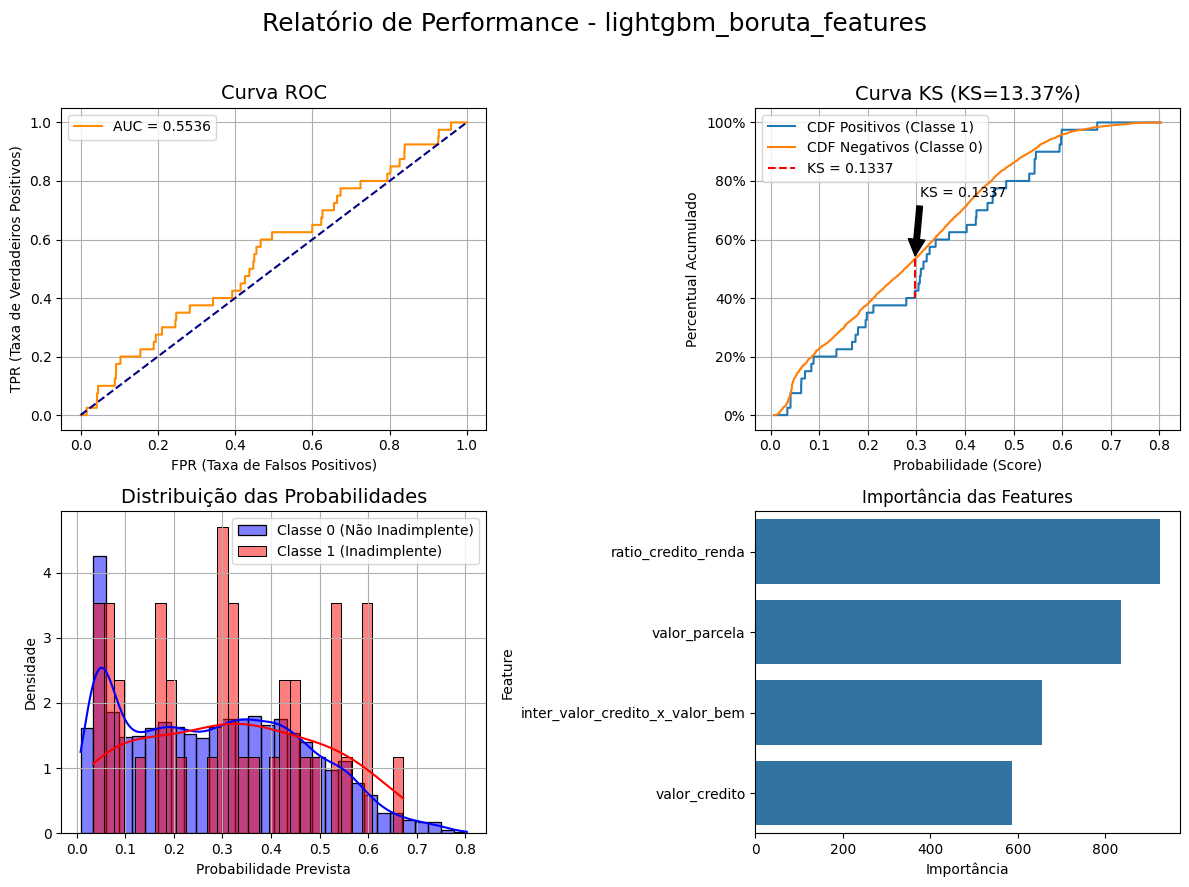

Modelo salvo em: /Users/jvlm/repositories/case-ds/models/lightgbm_boruta_features.joblib


,Métrica,Valor
0,AUC (ROC),0.5812
1,PR-AUC,0.0055
2,KS Statistic,0.1603
3,KS Threshold,0.1308
4,Precision (no KS),0.0051
5,Recall (no KS),0.6750


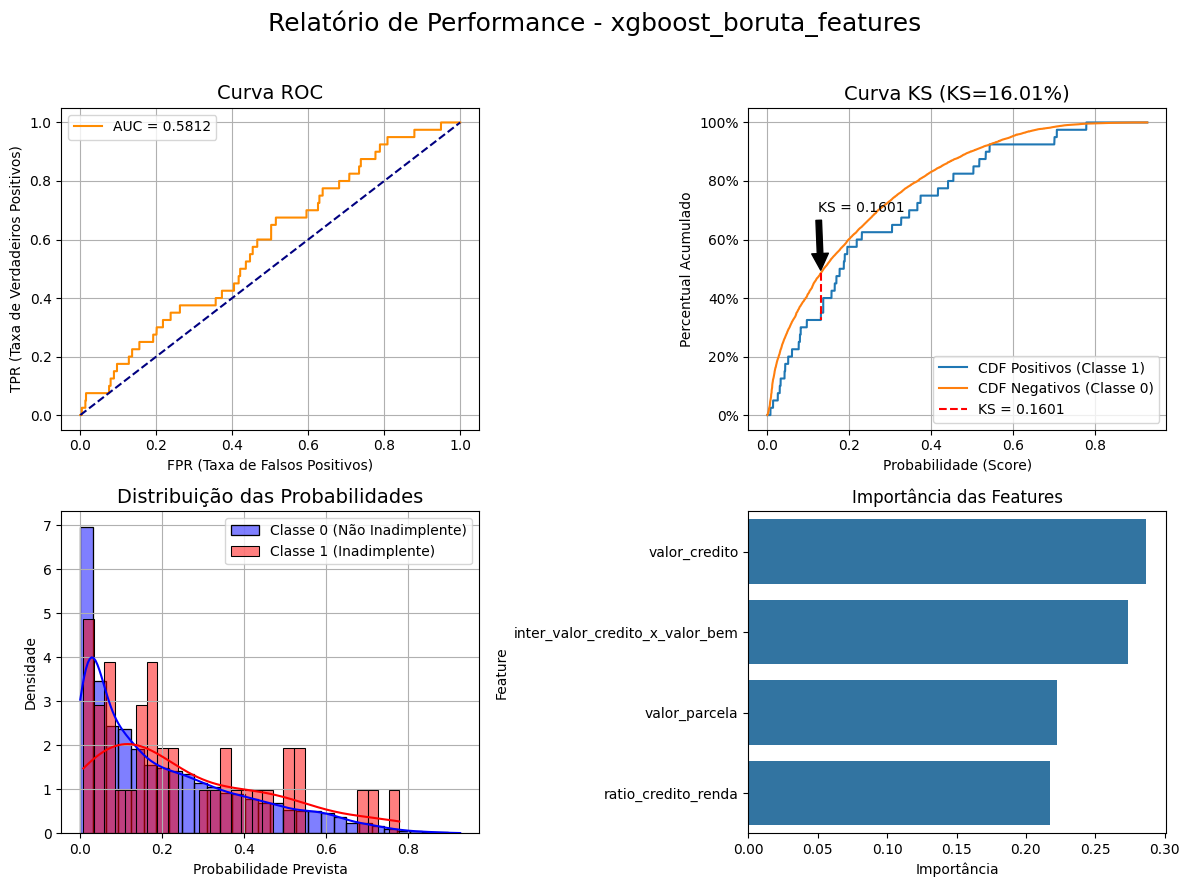

Modelo salvo em: /Users/jvlm/repositories/case-ds/models/xgboost_boruta_features.joblib


,Métrica,Valor
0,AUC (ROC),0.5322
1,PR-AUC,0.0045
2,KS Statistic,0.1158
3,KS Threshold,0.0693
4,Precision (no KS),0.0045
5,Recall (no KS),0.8250


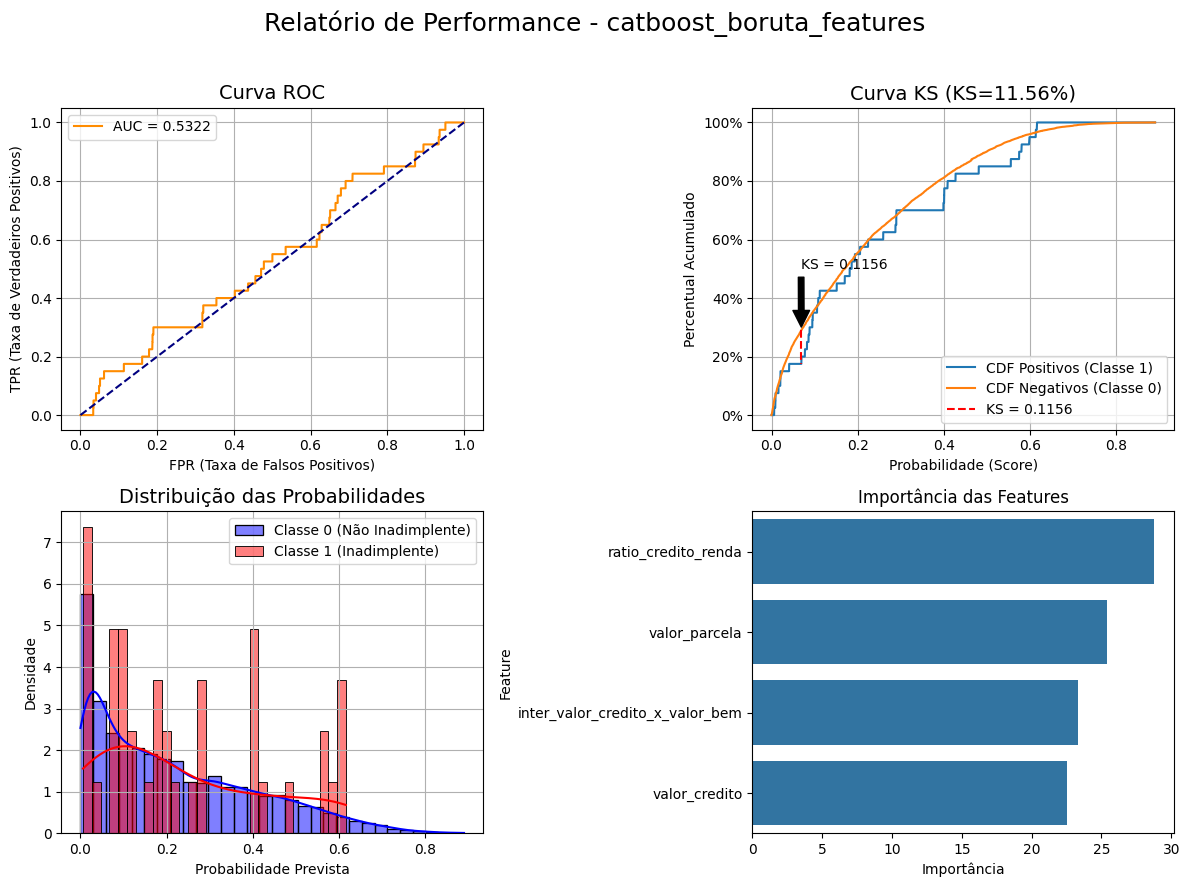

Modelo salvo em: /Users/jvlm/repositories/case-ds/models/catboost_boruta_features.joblib


In [193]:
params_lgbm = {
    'class_weight': 'balanced',
    'seed': 42,
    'verbosity': -1  # silencia logs do LightGBM
}

params_xgboost = {
    'scale_pos_weight': get_scale_pos_weight(y_train),
    'seed': 42,
    'verbosity': 0,         # silencia logs do XGBoost
    'use_label_encoder': False
}

params_catboost = {
    'auto_class_weights': 'Balanced',
    'random_seed': 42,
    'logging_level': 'Silent'  # manter apenas logging_level
}

# Criar os modelos baseline
model_lgbm = lgb.LGBMClassifier(**params_lgbm)
model_xgboost = xgb.XGBClassifier(**params_xgboost)
model_catboost = cat.CatBoostClassifier(**params_catboost)

# Executar experimentos baseline (apenas uma vez)
run_experiment(model_lgbm, X_train=X_train_boruta, X_test=X_test_boruta, experiment_name='lightgbm_boruta_features')
run_experiment(model_xgboost, X_train=X_train_boruta, X_test=X_test_boruta, experiment_name='xgboost_boruta_features')
run_experiment(model_catboost, X_train=X_train_boruta, X_test=X_test_boruta, experiment_name='catboost_boruta_features')

In [ ]:
params = {
    'class_weight': 'balanced',
    'seed': 42
}

# Criar o modelo LightGBM
model = lgb.LGBMClassifier(**params)
y_pred_proba, y_pred = fit_and_predict(model, X_train=X_train_boruta, X_test=X_test_boruta)

run_experiment(model, experiment_name='lightgbm_boruta_features',
               X_train=X_train_boruta, y_train=y_train,
               X_test=X_test_boruta, y_test=y_test)

,Métrica,Valor
0,AUC (ROC),0.5978
1,PR-AUC,0.0058
2,KS Statistic,0.1980
3,KS Threshold,0.4050
4,Precision (no KS),0.0070
5,Recall (no KS),0.4773


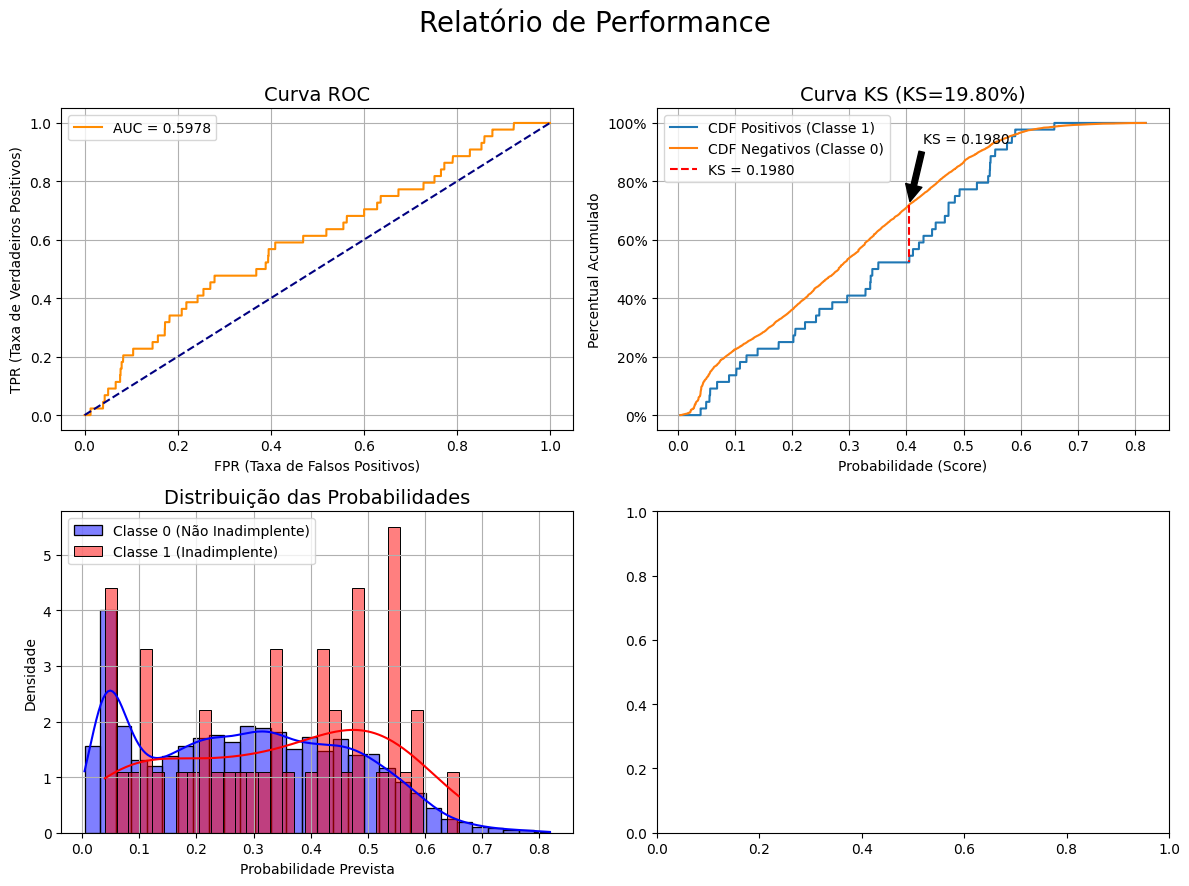

In [537]:
plot_report(y_test, y_pred_proba)

## **SMOTE**

In [538]:
from imblearn.over_sampling import SMOTE
from collections import Counter

In [539]:
counter = Counter(y_train)
print(counter)

Counter({0.0: 48417, 1.0: 1313})


In [540]:
oversample = SMOTE(sampling_strategy=0.1)
X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)

In [541]:
counter = Counter(y_train_smote)
print(counter)

Counter({0.0: 48417, 1.0: 4841})


In [ ]:
model = lgb.LGBMClassifier()
y_pred_proba, y_pred = fit_and_predict(model, X_train=X_train_smote, y_train=y_train_smote)

,Métrica,Valor
0,AUC (ROC),0.5984
1,PR-AUC,0.0059
2,KS Statistic,0.2204
3,KS Threshold,0.0144
4,Precision (no KS),0.0074
5,Recall (no KS),0.5000


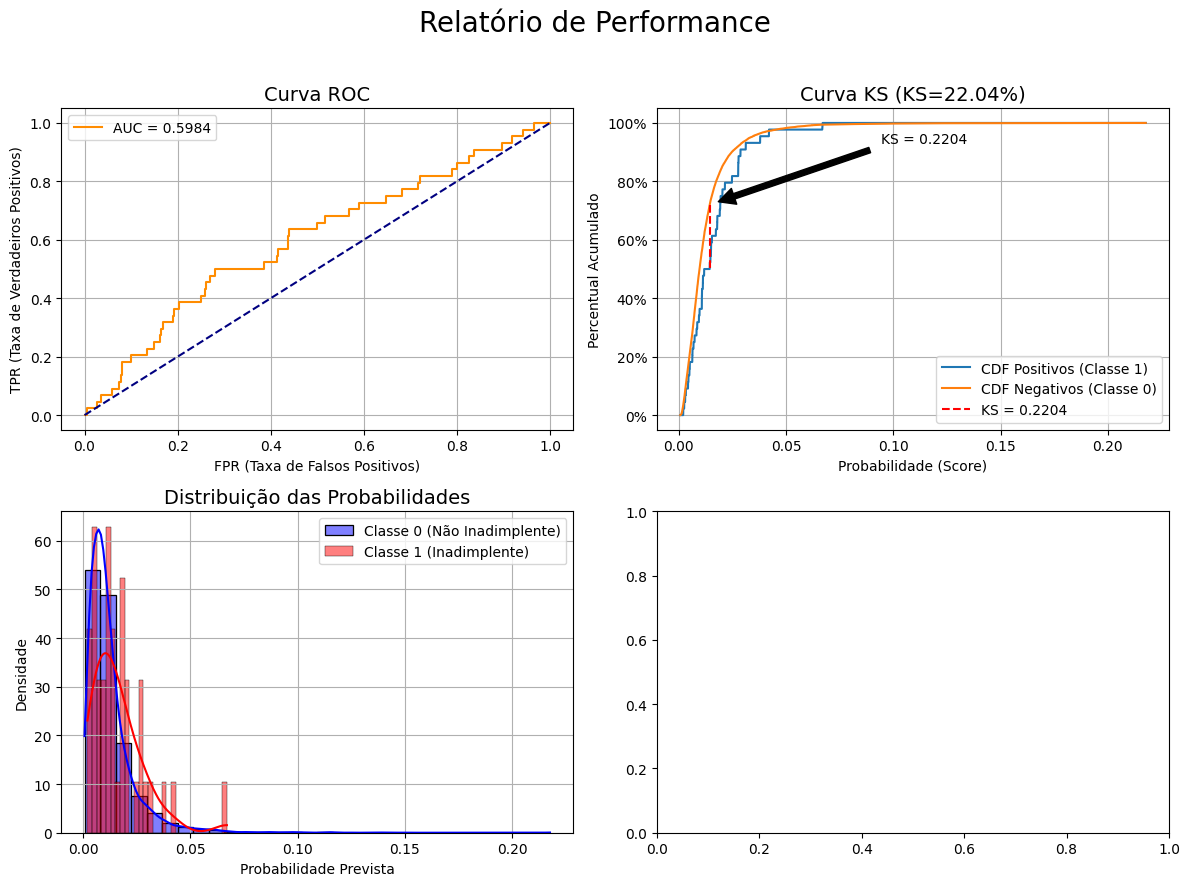

In [ ]:
show_report(model, y_test, y_pred_proba)

## Otimiza Hiperparâmetros com Optuna

In [22]:
search_spaces = {
    "lightgbm": {
        "n_estimators": lambda trial: trial.suggest_int("n_estimators", 200, 2000),
        "learning_rate": lambda trial: trial.suggest_float("learning_rate", 0.005, 0.1, log=True),
        "num_leaves": lambda trial: trial.suggest_int("num_leaves", 20, 500),
        "max_depth": lambda trial: trial.suggest_int("max_depth", 3, 12),
        "lambda_l1": lambda trial: trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": lambda trial: trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "feature_fraction": lambda trial: trial.suggest_float("feature_fraction", 0.6, 1.0),
        "bagging_fraction": lambda trial: trial.suggest_float("bagging_fraction", 0.6, 1.0),
        "bagging_freq": lambda trial: trial.suggest_int("bagging_freq", 1, 7),
    },
    "xgboost": {
        "n_estimators": lambda trial: trial.suggest_int("n_estimators", 200, 2000),
        "learning_rate": lambda trial: trial.suggest_float("learning_rate", 0.005, 0.1, log=True),
        "max_depth": lambda trial: trial.suggest_int("max_depth", 3, 12),
        "subsample": lambda trial: trial.suggest_float("subsample", 0.6, 1.0), # Equivalente a bagging_fraction
        "colsample_bytree": lambda trial: trial.suggest_float("colsample_bytree", 0.6, 1.0), # Equivalente a feature_fraction
        "reg_alpha": lambda trial: trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True), # L1
        "reg_lambda": lambda trial: trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True), # L2
        "gamma": lambda trial: trial.suggest_float("gamma", 1e-8, 1.0, log=True),
    },
    "catboost": {
        "iterations": lambda trial: trial.suggest_int("iterations", 200, 2000), # Equivalente a n_estimators
        "learning_rate": lambda trial: trial.suggest_float("learning_rate", 0.005, 0.1, log=True),
        "depth": lambda trial: trial.suggest_int("depth", 3, 12), # Equivalente a max_depth
        "l2_leaf_reg": lambda trial: trial.suggest_float("l2_leaf_reg", 1e-8, 10.0, log=True), # L2
        "subsample": lambda trial: trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bylevel": lambda trial: trial.suggest_float("colsample_bylevel", 0.6, 1.0),
        "random_strength": lambda trial: trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
    }
}

params_lgbm = {
    'class_weight': 'balanced',
    'seed': 42,
    'verbosity': -1  # silencia logs do LightGBM
}

params_xgboost = {
    'scale_pos_weight': get_scale_pos_weight(y_train),
    'seed': 42,
    'verbosity': 0,         # silencia logs do XGBoost
}

params_catboost = {
    'auto_class_weights': 'Balanced',
    'random_seed': 42,
    'logging_level': 'Silent'  # manter apenas logging_level
}

In [17]:
def objective(trial, model_name, X_train, y_train, X_val, y_val):
    """
    Função genérica que o Optuna irá otimizar.
    Ela recebe o nome do modelo, busca seus parâmetros e retorna o score (AUC).
    """
    # 1. Seleciona o espaço de busca para o modelo atual
    model_search_space = search_spaces[model_name]

    # 2. Cria o dicionário de parâmetros usando as sugestões do trial
    params = {name: func(trial) for name, func in model_search_space.items()}

    # 3. Instancia o modelo correto com base no nome
    if model_name == "lightgbm":
        model = lgb.LGBMClassifier(objective='binary', verbosity=-1, random_state=42, **params)
    elif model_name == "xgboost":
        model = xgb.XGBClassifier(objective='binary:logistic', random_state=42, use_label_encoder=False, **params)
    elif model_name == "catboost":
        model = cat.CatBoostClassifier(loss_function='Logloss', random_seed=42, verbose=0, **params)

    # 4. Treina e avalia o modelo
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred_proba)
    
    return auc

In [23]:
def save_model_and_metrics(model, metrics, model_name):

    model_package = {
        'model': model,
        'metrics': metrics
    }

    # Cria o diretório se não existir
    model_dir = os.path.join(project_root, 'modelsv2')
    os.makedirs(model_dir, exist_ok=True)

    # Salva o modelo
    model_filename = f"{model_name}.joblib"
    with open(os.path.join(model_dir, model_filename), "wb") as f:
        joblib.dump(model_package, os.path.join(model_dir, model_filename))

    print(f"Modelo salvo em: {os.path.join(model_dir, model_filename)}")

[I 2025-10-23 19:55:48,944] A new study created in memory with name: lightgbm_optimization



--- Otimizando LIGHTGBM ---


[I 2025-10-23 19:56:08,942] Trial 0 finished with value: 0.6147206261624731 and parameters: {'n_estimators': 1798, 'learning_rate': 0.023969485391958045, 'num_leaves': 423, 'max_depth': 11, 'lambda_l1': 0.0037407920476285545, 'lambda_l2': 2.855837642988594, 'feature_fraction': 0.6369986303025549, 'bagging_fraction': 0.9696176729044775, 'bagging_freq': 1}. Best is trial 0 with value: 0.6147206261624731.
[I 2025-10-23 19:56:11,851] Trial 1 finished with value: 0.6278606345979658 and parameters: {'n_estimators': 352, 'learning_rate': 0.03890278090827521, 'num_leaves': 458, 'max_depth': 8, 'lambda_l1': 0.00034347671302017876, 'lambda_l2': 0.006655605136651563, 'feature_fraction': 0.8753577617586756, 'bagging_fraction': 0.6579962797092614, 'bagging_freq': 5}. Best is trial 1 with value: 0.6278606345979658.
[I 2025-10-23 19:56:13,914] Trial 2 finished with value: 0.6186742447814032 and parameters: {'n_estimators': 230, 'learning_rate': 0.038530874460100215, 'num_leaves': 409, 'max_depth': 8,

Melhor AUC para lightgbm: 0.6581
Melhores parâmetros:
  n_estimators: 1820
  learning_rate: 0.00808759270721262
  num_leaves: 232
  max_depth: 3
  lambda_l1: 0.034588003541007585
  lambda_l2: 2.4692340105279463e-05
  feature_fraction: 0.9230650624241435
  bagging_fraction: 0.7675486038741773
  bagging_freq: 2


,Métrica,Valor
0,AUC (ROC),0.6538
1,PR-AUC,0.0087
2,KS Statistic,0.2881
3,KS Threshold,0.2147
4,Precision (no KS),0.0070
5,Recall (no KS),0.6500


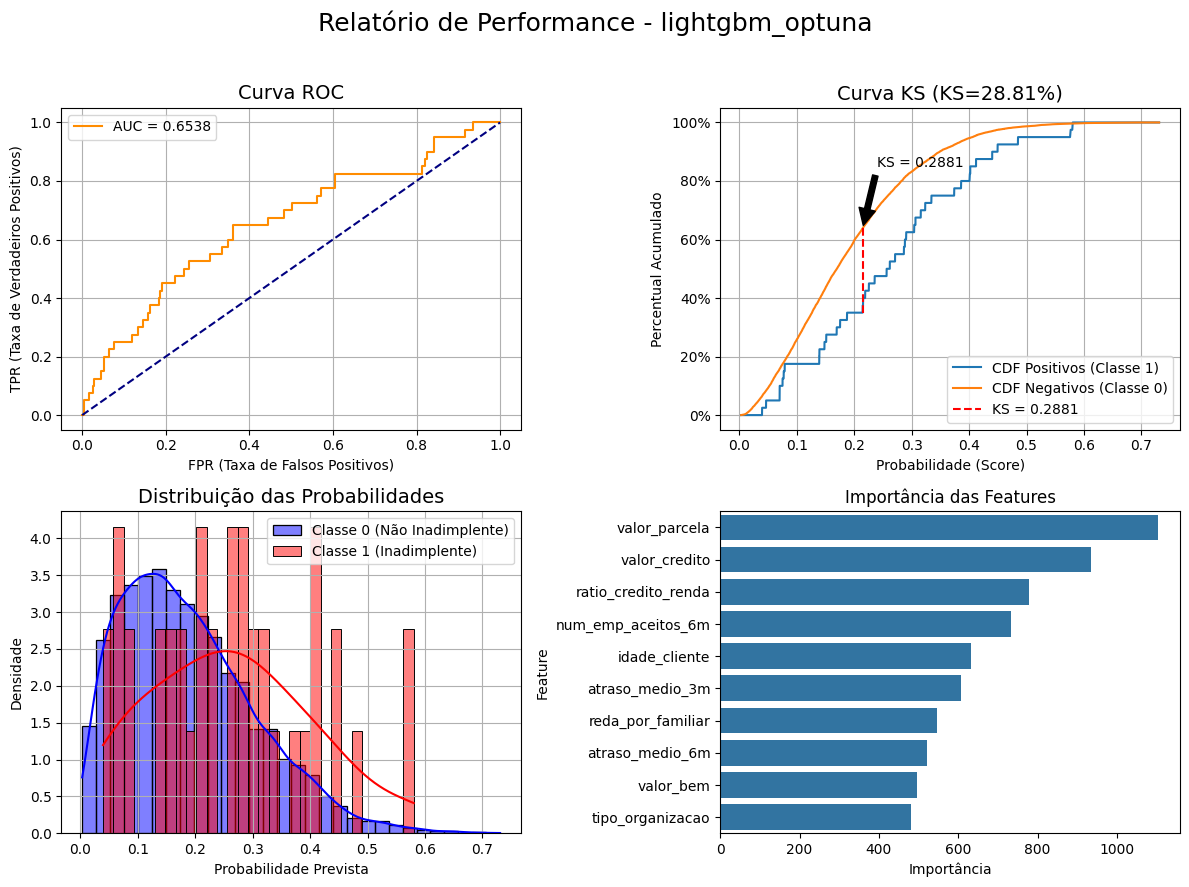

[I 2025-10-23 20:02:20,856] A new study created in memory with name: xgboost_optimization


Modelo salvo em: /teamspace/studios/this_studio/case-ds/models/lightgbm_optuna.joblib

--- Otimizando XGBOOST ---


/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [20:02:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-10-23 20:02:25,789] Trial 0 finished with value: 0.6292407365153116 and parameters: {'n_estimators': 571, 'learning_rate': 0.04156682491553102, 'max_depth': 8, 'subsample': 0.7804260715225185, 'colsample_bytree': 0.682892988538337, 'reg_alpha': 0.00013065479362620247, 'reg_lambda': 3.9538138118068864, 'gamma': 3.818799075814085e-07}. Best is trial 0 with value: 0.6292407365153116.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [20:02:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-10-23 20:02:40,494] Trial 1 finished with value: 0.6225711658265746 and parameters: {'n_estimato

Melhor AUC para xgboost: 0.6412
Melhores parâmetros:
  n_estimators: 1532
  learning_rate: 0.01306174362416739
  max_depth: 5
  subsample: 0.9245988774783486
  colsample_bytree: 0.760719574017221
  reg_alpha: 5.37197384926667
  reg_lambda: 0.0012457806059998384
  gamma: 0.8665288121732606


,Métrica,Valor
0,AUC (ROC),0.6225
1,PR-AUC,0.0075
2,KS Statistic,0.2505
3,KS Threshold,0.1671
4,Precision (no KS),0.0094
5,Recall (no KS),0.4250


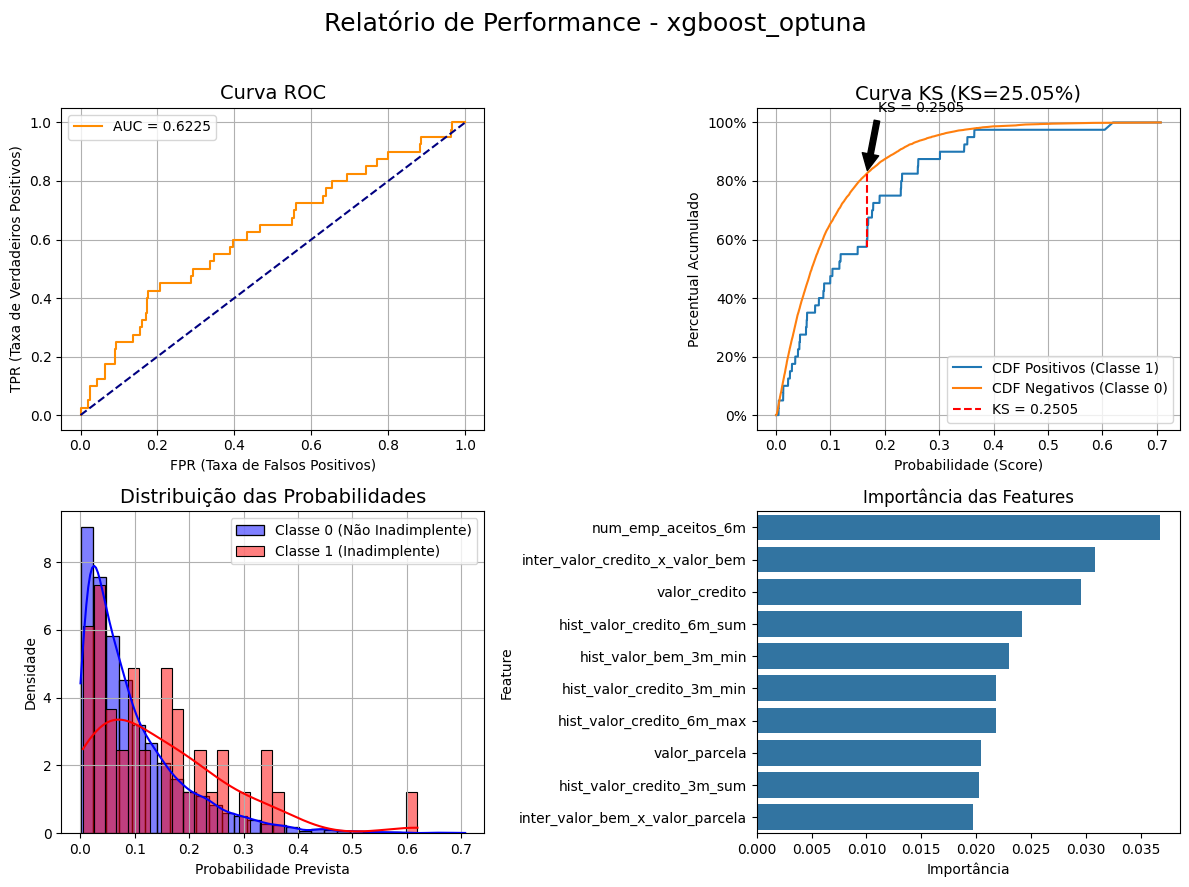

[I 2025-10-23 20:08:14,629] A new study created in memory with name: catboost_optimization


Modelo salvo em: /teamspace/studios/this_studio/case-ds/models/xgboost_optuna.joblib

--- Otimizando CATBOOST ---


Training has stopped (degenerate solution on iteration 1392, probably too small l2-regularization, try to increase it)
[I 2025-10-23 20:08:45,972] Trial 0 finished with value: 0.5515463917525774 and parameters: {'iterations': 1713, 'learning_rate': 0.020394636905473478, 'depth': 8, 'l2_leaf_reg': 0.00021716107301297916, 'subsample': 0.7657451662399894, 'colsample_bylevel': 0.8148711137583997, 'random_strength': 3.272331360441417e-07}. Best is trial 0 with value: 0.5515463917525774.
Training has stopped (degenerate solution on iteration 388, probably too small l2-regularization, try to increase it)
[I 2025-10-23 20:09:54,938] Trial 1 finished with value: 0.5678510928111625 and parameters: {'iterations': 1786, 'learning_rate': 0.01186372640477587, 'depth': 12, 'l2_leaf_reg': 0.000170740253857652, 'subsample': 0.9695582952746921, 'colsample_bylevel': 0.8445074802145697, 'random_strength': 0.8325448343747386}. Best is trial 1 with value: 0.5678510928111625.
Training has stopped (degenerate

Melhor AUC para catboost: 0.6458
Melhores parâmetros:
  iterations: 874
  learning_rate: 0.026141632122352876
  depth: 6
  l2_leaf_reg: 9.972355523692126
  subsample: 0.7299166931562137
  colsample_bylevel: 0.8914499879865462
  random_strength: 8.875398997910218e-08


,Métrica,Valor
0,AUC (ROC),0.6443
1,PR-AUC,0.0074
2,KS Statistic,0.2814
3,KS Threshold,0.0766
4,Precision (no KS),0.0059
5,Recall (no KS),0.8250


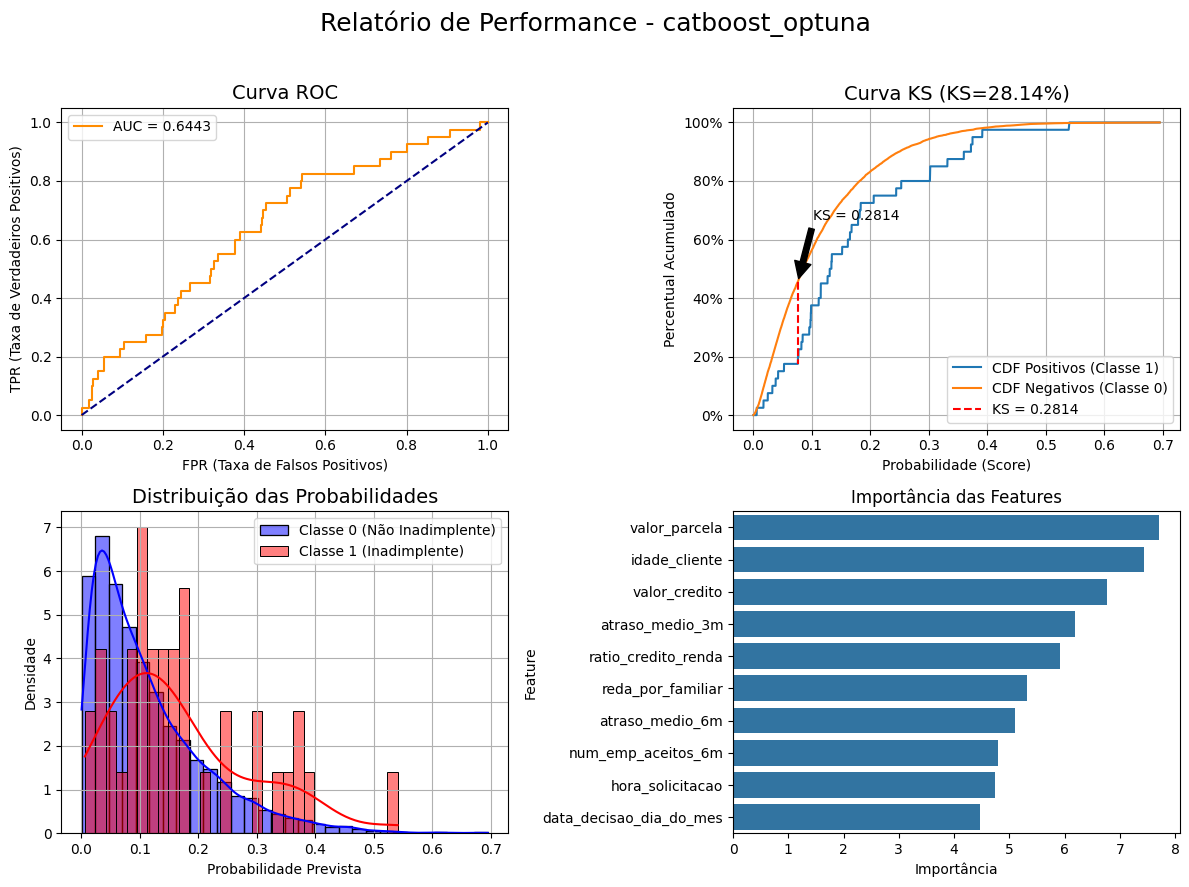

Modelo salvo em: /teamspace/studios/this_studio/case-ds/models/catboost_optuna.joblib


In [24]:
best_results = {}

for model_name in search_spaces.keys():
    print(f"\n--- Otimizando {model_name.upper()} ---")

    # Cria um estudo para o modelo atual
    study = optuna.create_study(direction='maximize', study_name=f"{model_name}_optimization")

    # Otimiza a função objective, passando os argumentos extras através de um lambda
    study.optimize(
        lambda trial: objective(trial, model_name, X_train, y_train, X_val, y_val),
        n_trials=50  # Defina o número de tentativas que desejar
    )

    # Guarda os melhores resultados
    best_results[model_name] = {
        "best_value": study.best_value,
        "best_params": study.best_trial.params
    }

    print(f"Melhor AUC para {model_name}: {study.best_value:.4f}")
    print("Melhores parâmetros:")
    for key, value in study.best_trial.params.items():
        print(f"  {key}: {value}")

    # Instancia o modelo apropriado para o tipo otimizado
    best_params = study.best_trial.params
    if model_name == "lightgbm":
        model = lgb.LGBMClassifier(**params_lgbm, **best_params)
    elif model_name == "xgboost":
        model = xgb.XGBClassifier(**params_xgboost, **best_params)
    elif model_name == "catboost":
        model = cat.CatBoostClassifier(**params_catboost, **best_params)

    run_experiment(model, experiment_name=f"{model_name}_optuna")

### Referências

https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

https://medium.com/@balemar/t%C3%A9cnicas-para-dados-desbalanceados-smote-e-adasyn-f891f9c46c6e